# Example Data Processing Workflows



## The dfits_fitsort utility

This is a Python implementation of the dfits and fitsort shell script workflows. The cell below makes a table of all the fits files in the raw directory that star with "o", and tells you whether the dome flat light was on or off. This is useful for inspecting the raw data. On the command line this was:

dfits directory/\o*.fits | fitsort OBJECT FILTER FLSPECTR

The benefit of doing this in Python is easy manipulation of the output table, which is showcased by the multi_reduce subpackage.

In [1]:
from nirc2_reduce.sort_rawfiles import dfits_fitsort

wildcard = '/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/raw/o*.fits'
tab = dfits_fitsort(wildcard, ["OBJECT", "FILTER", "FLSPECTR"])
print(type(tab))
tab

<class 'astropy.table.table.Table'>


FILENAME,OBJECT,FILTER,FLSPECTR
str72,str72,str72,str72
/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/raw/off0.fits,domeflatoff,H + clear,off
/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/raw/off1.fits,domeflatoff,H + clear,off
/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/raw/off2.fits,domeflatoff,H + clear,off
/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/raw/off3.fits,domeflatoff,H + clear,off
/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/raw/off4.fits,domeflatoff,H + clear,off
/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/raw/on0.fits,domeflaton,H + clear,on
/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/raw/on1.fits,domeflaton,H + clear,on
/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/raw/on2.fits,domeflaton,H + clear,on
/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/raw/on3.fits,domeflaton,H + clear,on


## Basic Imaging Data Reduction

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

### On-Off Nod

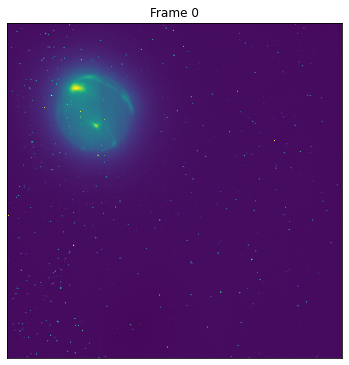

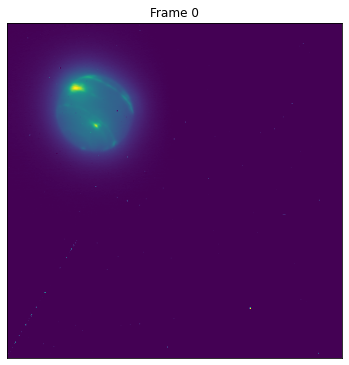

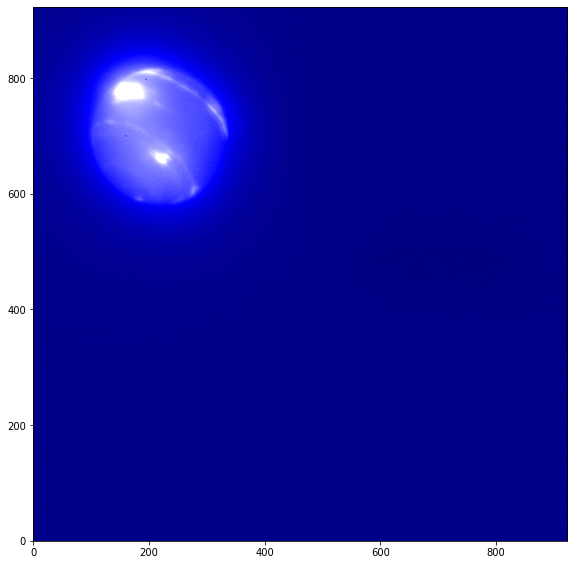

In [3]:
from nirc2_reduce.observation import Nod

stem = '/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/'
data_fname = stem+'raw/bxy3_1.fits'
sky_fname = stem+'sky_expected.fits'
flat_fname = stem+'flat_expected.fits'
badpx_fname = stem+'badpx_map_expected.fits'
instrument = 'nirc2'

obs = Nod(data_fname, sky_fname, instrument)
obs.plot_frames(figsz=6)
# custom plot here to make it show up nicer in notebook
obs.apply_sky()
obs.apply_flat(flat_fname)
obs.plot_frames(figsz=6)
obs.apply_badpx_map(badpx_fname)
obs.dewarp()
obs.remove_cosmic_rays()
obs.per_second()

# hack to use crop_final() and plot_final()
# self.final is normally defined after stacking individual frames, which is not necessary for on-off nod
obs.final = obs.frames[0] 
obs.crop_final(50)
obs.plot_final(show=True, png_file=None) #save with png_file="whatever.png"
#obs.write_final('output.fits')

### Generic Dither

In [4]:
from nirc2_reduce.observation import DitherN

stem = '/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/'
data_fnames = [stem+'raw/bxy3_1.fits', stem+'raw/bxy3_2.fits', stem+'raw/bxy3_3.fits']
flat_fname = stem+'flat_expected.fits'
badpx_fname = stem+'badpx_map_expected.fits'
sky_fname = stem+'sky_expected.png'
instrument = 'nirc2'

#obs = DitherN()

### Bxy3

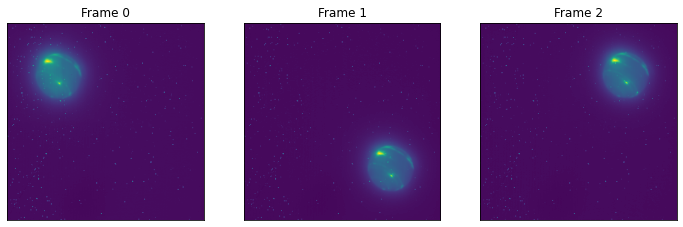

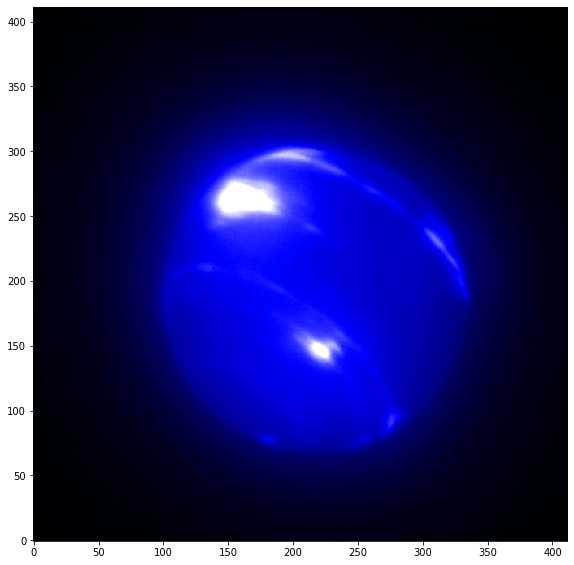

In [5]:
from nirc2_reduce.observation import Bxy3

stem = '/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/'
data_fnames = [stem+'raw/bxy3_1.fits', stem+'raw/bxy3_2.fits', stem+'raw/bxy3_3.fits']
flat_fname = stem+'flat_expected.fits'
badpx_fname = stem+'badpx_map_expected.fits'
sky_fname = stem+'sky_expected.png'
instrument = 'nirc2'

obs = Bxy3(data_fnames, 'nirc2')
obs.plot_frames(figsz=4)
obs.make_sky(sky_fname) #writes
obs.apply_sky(sky_fname) #reads in again
obs.apply_flat(flat_fname)
obs.apply_badpx_map(badpx_fname)
obs.dewarp()
obs.remove_cosmic_rays()
obs.rotate(beta=0.252)
obs.per_second()
#obs.write_frames([outdir+'frame0_nophot_'+filt_name+'.fits',outdir+'frame1_nophot_'+filt_name+'.fits',outdir+'frame2_nophot_'+filt_name+'.fits'])
obs.trim()
obs.stack()
obs.crop_final(50)
#check final
obs.plot_final(show=True, png_file=None) #save with png_file="whatever.png"
#obs.write_final(outdir+'stacked_nophot_'+filt_name+'.fits')#,png=True, png_file = outdir+target_name+'_'+filt_name+'.png')

## Darks, Flats and Bad Pixel Maps

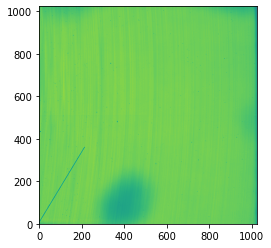

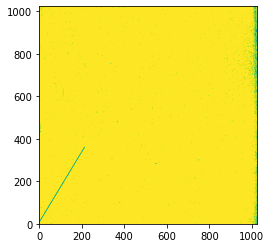

In [6]:
from nirc2_reduce.flats import Flats

stem = '/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/'
flat_fname = stem+'flat_expected.fits'
badpx_fname = stem+'badpx_map_expected.fits'
off_fnames = [f'{stem}raw/off{i}.fits' for i in range(5)]
on_fnames = [f'{stem}raw/on{i}.fits' for i in range(5)]

flat = Flats(off_fnames, on_fnames)
flat.plot()
flat.write(flat_fname)
flat.make_badpx_map(badpx_fname, tol=0.07, blocksize=6)
plt.imshow(flat.badpx_map, origin='lower')
plt.show()

## Process Multiple Images at Once

If you know all the data reductions in a given raw folder are straightforward, e.g., if they were themselves taken with automated scripts like for the [Keck Twilight Zone](https://www2.keck.hawaii.edu/inst/tda/TwilightZone.html#) progam, then these workflows are for you! The script below will attempt the following steps:
- sort the raw files in the input rawdir into a table
- figure out if any raw files are dome flats
- make master flats and bad pixel maps for each filter that dome flats were found
- save flats in the flatdir
- apply the Bxy3 workflow on all science data (sorting by target name and filter)
- save the results, including individual frames, to the reddir.

In [7]:
from nirc2_reduce.multi_reduce import MultiBxy3

instrument="nirc2"
rawdir = '/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/raw/'
reddir = '/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/reduced/'
flatdir = '/Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/flats/'

obs = MultiBxy3(rawdir, instrument) # finds bxy3 data reductions to do inside
obs.process_flats(flatdir)  # looks for raw flat frames in rawdir, puts into flatdir
obs.run(reddir, flatdir)

wrote files /Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/flats/2017-07-25_flat_master_h.fits and /Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/flats/2017-07-25_badpx_map_h.fits
Starting object HD1160 (1 of 2)
Starting filter H + clear (1 of 1)
No custom colormap defined for target, setting to default
Object HD1160 finished with 0 failed filters
Starting object Neptune 15:00 (2 of 2)
Starting filter H + clear (1 of 1)
Object Neptune finished with 0 failed filters


In [8]:
# cleanup (for testing)
!rm /Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/flats/*
!rm /Users/emolter/Python/nirc2_reduce/nirc2_reduce/tests/data/reduced/*